In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [102]:
train_data = pd.read_csv("train_data.csv")
val_data = pd.read_csv("val_data.csv")
test_data = pd.read_csv("test_data.csv")

In [463]:
unique_quad_train = train_data["quad_id"].unique()
train = []
x, y = [12,3]
sc=int(30/y)
for quad in unique_quad_train:
    df = train_data[train_data["quad_id"] == quad]
    for i in range(0, len(df)-y-x, y*sc):
        start_idx = i 
        end_idx = start_idx + x 
        final_end_idx = end_idx + y
        pair_x = df.iloc[start_idx:end_idx]["txn_cnt"].to_numpy()
        pair_y = df.iloc[end_idx:final_end_idx]["txn_cnt"].to_numpy()
        train.append([pair_x, pair_y])
        

unique_quad_val = val_data["quad_id"].unique()
val = []

for quad in unique_quad_val:
    df = val_data[val_data["quad_id"] == quad]
    for i in range(0, len(df)-y-x, y*sc):
        start_idx = i 
        end_idx = start_idx + x 
        final_end_idx = end_idx + y
        pair_x = df.iloc[start_idx:end_idx]["txn_cnt"].to_numpy()
        pair_y = df.iloc[end_idx:final_end_idx]["txn_cnt"].to_numpy()
        val.append([pair_x, pair_y])

unique_quad_test = test_data["quad_id"].unique()
test = []

for quad in unique_quad_test:
    df = test_data[test_data["quad_id"] == quad]
    for i in range(0, len(df)-y-x, y*sc):
        start_idx = i 
        end_idx = start_idx + x 
        final_end_idx = end_idx + y
        pair_x = df.iloc[start_idx:end_idx]["txn_cnt"].to_numpy()
        pair_y = df.iloc[end_idx:final_end_idx]["txn_cnt"].to_numpy()
        test.append([pair_x, pair_y])

# create dataloader

## train

In [464]:
train_x = np.array([entry[0] for entry in train])
train_y = np.array([entry[1] for entry in train])

In [465]:
# Convert data to PyTorch tensors
X_reg_train_tensor = torch.FloatTensor(train_x).to(torch.float64)
y_reg_train_tensor = torch.FloatTensor(train_y).to(torch.float64)
train_dataset_reg = TensorDataset(X_reg_train_tensor, y_reg_train_tensor)
train_loader_reg = DataLoader(train_dataset_reg, batch_size=32, shuffle=True)

## val

In [466]:
val_x = np.array([entry[0] for entry in val])
val_y = np.array([entry[1] for entry in val])

In [467]:
# Optionally, validate the regression model on a validation set
X_reg_val_tensor = torch.FloatTensor(val_x).to(torch.float64)
y_reg_val_tensor = torch.FloatTensor(val_y).to(torch.float64)
val_dataset_reg = TensorDataset(X_reg_val_tensor, y_reg_val_tensor)
val_loader_reg = DataLoader(val_dataset_reg, batch_size=1, shuffle=False)

## test

In [468]:
test_x = np.array([entry[0] for entry in test])
test_y = np.array([entry[1] for entry in test])

In [469]:
# Convert data to PyTorch tensors
X_reg_test_tensor = torch.FloatTensor(test_x)
y_reg_test_tensor = torch.FloatTensor(test_y)
test_dataset_reg = TensorDataset(X_reg_test_tensor, y_reg_test_tensor)
test_loader_reg = DataLoader(test_dataset_reg, batch_size=1, shuffle=False)

In [471]:
np.random.seed(42)

# Define the Feedforward Neural Network (FNN) model for regression
class SimpleFNNRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFNNRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size).to(torch.float64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size*2).to(torch.float64)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(2*hidden_size, hidden_size*1).to(torch.float64)
        self.relu = nn.ReLU()
        self.fc5 = nn.Linear(1*hidden_size, output_size).to(torch.float64)

    def forward(self, x):
        x = self.fc1(x.to(torch.float64))
        x = self.relu(x)
        x = self.fc2(x.to(torch.float64))
        x = self.relu(x)
      #  x = self.fc3(x)
      #  x = self.relu(x)
        x = self.fc4(x.to(torch.float64))
        x = self.relu(x)
        x = self.fc5(x.to(torch.float64))
        return x

# Function to train the regression model
def train_regression_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, len_y=1, acc_treshold=10):
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            acc = torch.abs(outputs-targets)
            acc = len(acc[acc<acc_treshold])
           # print(acc)
            running_loss += loss.item()
            running_acc += acc
        
        average_acc = running_acc / (len(train_loader)*32*len_y)
        average_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.2f}, acc: {average_acc:.2f}')
        losses.append(average_loss)
        accuracies.append(average_acc)
        
        if epoch%5 == 0:
            model.eval()
            running_loss = 0.0
            running_acc = 0
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_loss += loss.item()
                
                acc = torch.abs(outputs-targets)
                acc = len(acc[acc<acc_treshold])
                running_acc += acc
            average_acc = running_acc / (len(val_loader)*len_y)    
            average_loss = running_loss / len(val_loader)
            print(f'Validation, Loss: {average_loss:.2f}, acc: {average_acc:.2f}')
            val_losses.append(average_loss)
            val_accuracies.append(average_acc)
        else:
            val_losses.append(val_losses[-1])
            val_accuracies.append(val_accuracies[-1])
            
    return model, [losses, val_losses, accuracies, val_accuracies]

# Split the data into training and validation sets
#X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)



# Instantiate the regression model, loss function, and optimizer
input_size_reg = train_x.shape[1]
output_size_reg = train_y.shape[1]  
hidden_size_reg = 64  # Adjust as needed
model_reg = SimpleFNNRegression(input_size_reg, hidden_size_reg, output_size_reg)
criterion_reg = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.001)

# Train the regression model
num_epochs_reg = 50  # Adjust as needed

np.random.seed(42)
model, history = train_regression_model(model_reg, train_loader_reg, val_loader_reg, criterion_reg, optimizer_reg, num_epochs_reg, y)


Epoch 1/25, Loss: 11075.20, acc: 0.45
Validation, Loss: 16398.23, acc: 0.42
Epoch 2/25, Loss: 9808.33, acc: 0.47
Epoch 3/25, Loss: 9643.66, acc: 0.47
Epoch 4/25, Loss: 10239.58, acc: 0.45
Epoch 5/25, Loss: 9237.37, acc: 0.47
Epoch 6/25, Loss: 9161.97, acc: 0.47
Validation, Loss: 13606.65, acc: 0.48
Epoch 7/25, Loss: 9194.57, acc: 0.47
Epoch 8/25, Loss: 9022.49, acc: 0.48
Epoch 9/25, Loss: 8943.19, acc: 0.46
Epoch 10/25, Loss: 8914.43, acc: 0.46
Epoch 11/25, Loss: 8702.66, acc: 0.47
Validation, Loss: 12291.17, acc: 0.51
Epoch 12/25, Loss: 8767.65, acc: 0.47
Epoch 13/25, Loss: 8687.10, acc: 0.47
Epoch 14/25, Loss: 8312.29, acc: 0.48
Epoch 15/25, Loss: 8577.92, acc: 0.46
Epoch 16/25, Loss: 8335.44, acc: 0.47
Validation, Loss: 11565.35, acc: 0.50
Epoch 17/25, Loss: 8515.77, acc: 0.46
Epoch 18/25, Loss: 8130.51, acc: 0.47
Epoch 19/25, Loss: 7877.24, acc: 0.47
Epoch 20/25, Loss: 7873.24, acc: 0.48
Epoch 21/25, Loss: 7784.92, acc: 0.47
Validation, Loss: 11771.56, acc: 0.51
Epoch 22/25, Loss: 

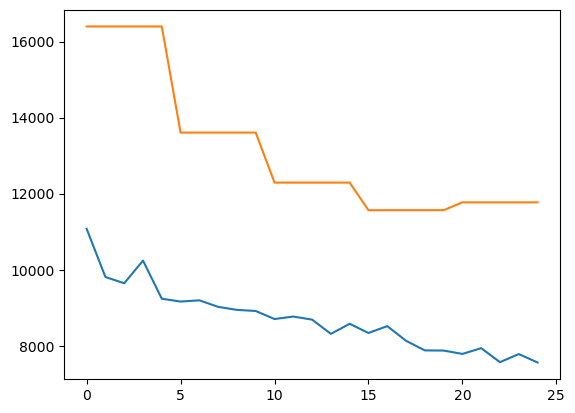

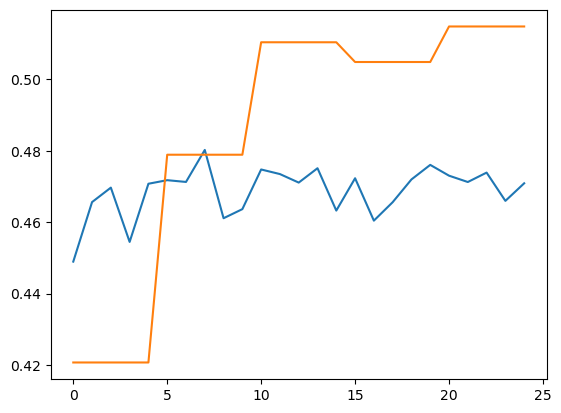

In [472]:
plt.plot(history[0])
plt.plot(history[1])
plt.show()
plt.plot(history[2])
plt.plot(history[3])
plt.show()

In [520]:
# 
inputs = torch.from_numpy(train_x[10][-12:]).to(torch.float64)
model.eval()
#model(inputs)

with torch.no_grad():
    predictions = model(inputs)
print(inputs)
print(predictions)


tensor([44.4735, 43.8887, 43.3038, 42.7190, 42.1342, 41.5493, 40.9645, 40.3797,
        39.7948, 39.2100, 39.6947, 40.1794], dtype=torch.float64)
tensor([55.2911, 47.8206, 58.3373], dtype=torch.float64)


In [498]:
predictions = model2(model, inputs)

In [407]:
torch.save(model1.state_dict(), "model.pt")